# Data Science Test @ RedPoints

## Part II. Churn prediction (brute force)

*Hector Hernandez Coronado*

*Barcelona, 2020-11-26*

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.pipeline import Pipeline

import itertools
import matplotlib.pyplot as plt
import os
import random
import pickle
from scipy.sparse import csr_matrix

## Load preprocessed dataset

In [2]:
contracts = pd.read_csv('contracts_full.csv', index_col=0)
# setting startdate unit to days
contracts['startdate'] = pd.to_datetime(contracts['startdate']).astype('int64') / (24*3600*10**9) 
contracts = contracts.drop(columns=['customer', 'contractid', 'enddate'])
contracts = contracts.fillna(0)
contracts

,brand,piracy,active,startdate,A_true_18-01,A_false_18-01,internal_B_true_18-01,external_B_true_18-01,B_true_18-01,internal_C_true_18-01,...,one_month_B_true_C_true_20-10,avg_time_start_C_true_20-10,median_time_start_C_true_20-10,min_time_start_C_true_20-10,max_time_start_C_true_20-10,avg_time_B_true_C_true_20-10,median_time_B_true_C_true_20-10,automatization_A_20-10,automatization_B_20-10,automatization_C_20-10
321,1,0,0,17828.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
320,1,0,0,17828.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
509,1,0,0,17980.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
281,1,0,1,17778.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,202.0,163.5,5.0,488.0,154.0,176.0,1.0,1.00,1.0
489,0,1,0,17968.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,1,0,1,17939.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.863636,32.0,8.0,1.0,315.0,31.0,6.0,0.5,0.25,1.0
22,1,0,0,17578.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
472,1,0,0,17956.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
214,1,0,0,17688.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0


## Plot features as function of date for both, active and inactive contracts

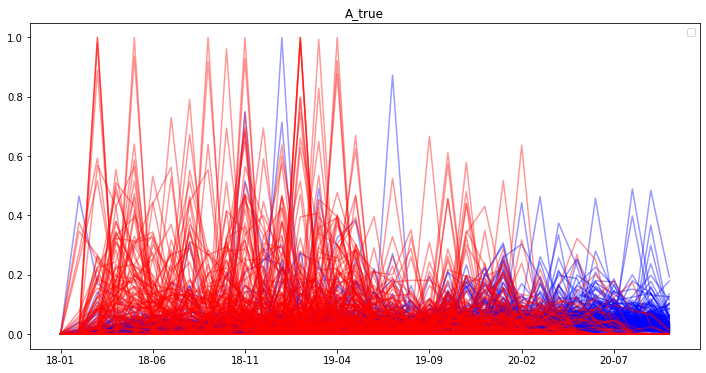

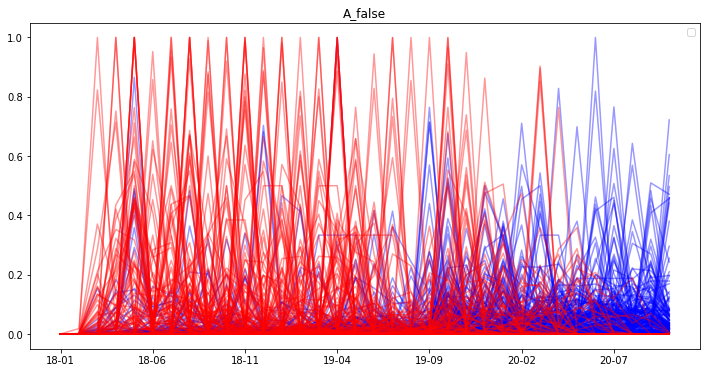

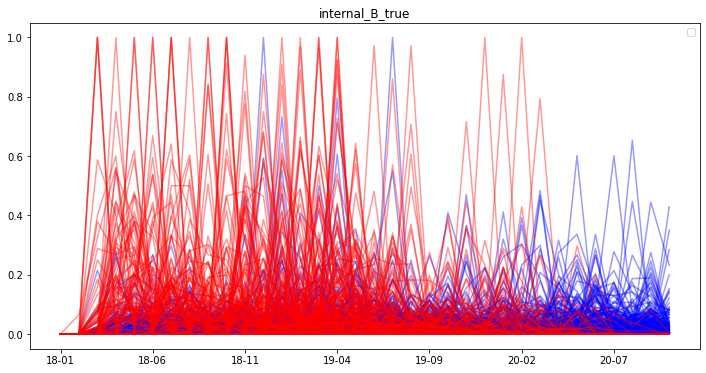

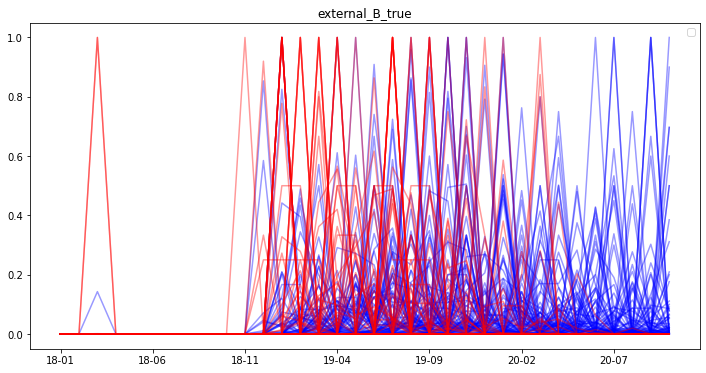

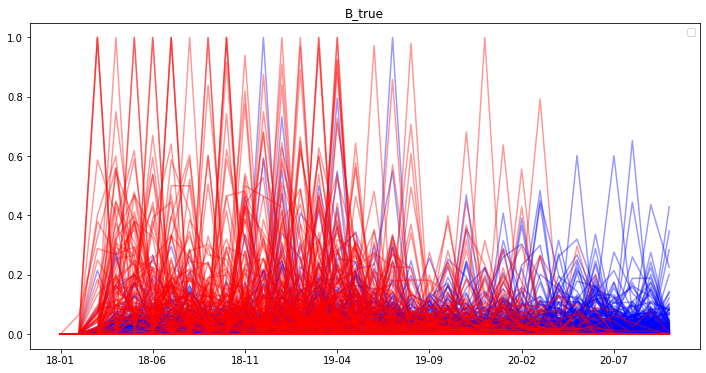

In [3]:
cols = contracts.columns[4:].map(lambda x: x[:-6]).unique()
for col in cols[:5]:
    feature_cols = [col == c[:-6] for c in contracts.columns]
    contracts.iloc[:,feature_cols]
    trues = pd.concat([contracts[['active']], contracts.iloc[:,feature_cols]], axis=1)
    trues_act = trues[trues.active == 1].iloc[:,1:]
    trues_act_norm = trues_act.T/trues_act.sum(axis=1)
    trues_inact = trues[trues.active == 0].iloc[:,1:]
    trues_inact_norm = trues_inact.T/trues_inact.sum(axis=1)
    ax = trues_act_norm.plot(figsize=(12,6), c='b', alpha=.4)
    trues_inact_norm.plot(figsize=(12,6), color='r', ax=ax, alpha=.4)
    labels = [item.get_text() for item in ax.get_xticklabels()]
    ax.set_xticklabels([l[-5:] for l in labels])
    plt.title(col)
    plt.legend('')
    plt.show()

In [9]:

def plot_learning_curve(estimator, title, X, y):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features).

    y : array-like, shape (n_samples) or (n_samples, n_features).

    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].set_title(title)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator, X, y, cv=5, n_jobs=4,train_sizes=np.linspace(0.1, 1, 6), return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-',
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', 
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

def plot_validation_curve(model):    
    '''
    Plots the score value as a function of regularization hyperparameter given the best values for the
    other possible hyperparameters.
    ------------------------------------------------------
    Input:
        model
        
    Output:
        plot
    '''
    fig, ax = plt.subplots(figsize=(15, 5))
    df = pd.DataFrame.from_dict(model.cv_results_)
    
    best_params = [v for k,v in model.best_params_.items() if k != 'LR__C']
    df_cv = df[(df['param_kbest__k'] == best_params[0]) 
               & df['param_scaler'].apply(lambda x: x == best_params[1])]
    df_cv = df_cv.set_index('param_LR__C')

    test_scores = df_cv['mean_test_score'].values
    test_std = df_cv['std_test_score'].values
    train_scores = df_cv['mean_train_score'].values
    train_std = df_cv['std_train_score'].values

    # plot validation curve
    ax.grid()
    df_cv[['mean_test_score', 'mean_train_score']].plot(kind='line', ax=ax, logx=True)
    ax.fill_between(df_cv.index, test_scores - test_std, test_scores + test_std, alpha = 0.1)
    ax.fill_between(df_cv.index, train_scores - train_std, train_scores + train_std, alpha = 0.1)
    ax.set_xlabel('param_LR__C')
    ax.set_ylabel("Score")
    ax.set_title("Validation curve. Best parameters: {}".format(model.best_params_))
    
        
    return plt


def train_classifier(df, test_size=0.3, random_state=42):
    '''
    Trains the logistic regression classifier to predict whether a 'contractid' is going to churn.
    ------------------------------------------------------------------
    Input:
        df. pd.DataFrame with the training examples.
        
    Output:
        LR classifier.
    '''
    ###############################
    ## Split train_test
    ## ----------------------------
    df_train, df_test = train_test_split(df, test_size=0.25, random_state=42)
    ###############################
    ## featurize 
    ## ----------------------------
    ## targets
    y_train = np.asarray(df_train['active']).astype(int) 
    y_test = np.asarray(df_test['active']).astype(int)
    ## features
    X_train = np.asarray(df_train.drop(columns='active').values)
    X_test = np.asarray(df_test.drop(columns='active').values)   
    ###############################
    ## Model
    ## ----------------------------
    LR = LogisticRegression(penalty='l2', max_iter=10000, tol=0.1, n_jobs=-1, solver='liblinear')
    
    param_grid = {'scaler': [StandardScaler(), RobustScaler()],
                  'kbest__k': [5, 10, 50],
                  'LR__C': np.logspace(-5, 5, 10)}
    pipeline = Pipeline(steps=[
                ('scaler', StandardScaler()), 
                ('kbest', SelectKBest()),
                ('LR', LR)], verbose=True)
    model = GridSearchCV(pipeline, param_grid, n_jobs=-1, scoring='roc_auc', return_train_score=True)
    model.fit(X_train, y_train)
    print("Best parameter (CV score=%0.3f):" % model.best_score_)
    print(model.best_params_)
    
    # Evaluating... validation    
    plot_validation_curve(model)
    plt.show()
    
    # learning curve
    #fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    plot_learning_curve(model, "Learning Curves (LogReg)", X_train, y_train)
    plt.show()
    
    # prediction
    print("Predicting matching records...")
    y_pred = model.predict(X_test)
    cnf_matrix = confusion_matrix(y_test, y_pred, labels=[1,0])
    np.set_printoptions(precision=4)

    # testing 
    print (classification_report(y_test, y_pred))
    # Plot non-normalized confusion matrix
    fig, ax = plt.subplots(figsize=(8,6))
    plot_confusion_matrix(model, X_test, y_test, cmap = plt.cm.Blues, ax=ax, normalize='true')
    plt.show()
    
    return model

# Training the model


Training model...
[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 3) Processing kbest, total=   0.0s
[Pipeline] ................ (step 3 of 3) Processing LR, total=   0.0s
Best parameter (CV score=0.979):
{'LR__C': 100000.0, 'kbest__k': 50, 'scaler': StandardScaler()}


/home/h/.local/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21
  22  26  29  66  69  86  89 106 109 126 129 146 149 166 169 186 189 206
 209] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/h/.local/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/h/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


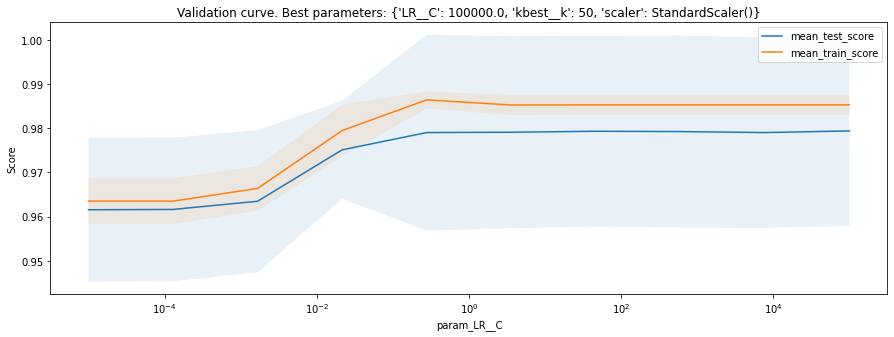

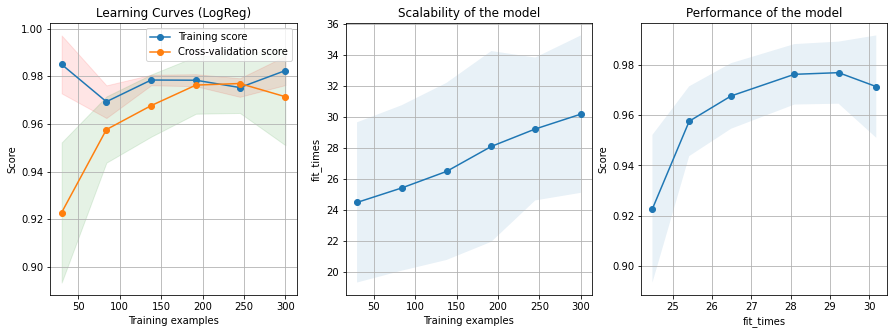

Predicting matching records...
              precision    recall  f1-score   support

           0       0.94      0.99      0.96        81
           1       0.98      0.89      0.93        45

    accuracy                           0.95       126
   macro avg       0.96      0.94      0.95       126
weighted avg       0.95      0.95      0.95       126



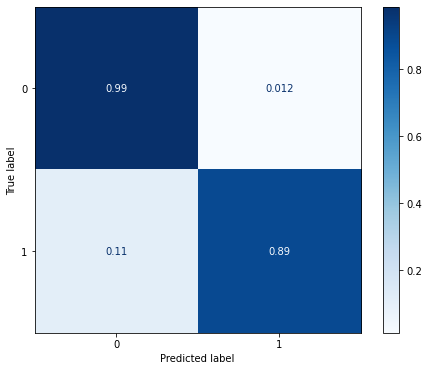

In [10]:
print('Training model...')
clf = train_classifier(contracts)

In [11]:
pba = (contracts.drop(columns='active').iloc[0:1].values)

In [12]:
model = clf.best_estimator_
model.named_steps['LR'].coef_
best_idx = model.named_steps['kbest'].get_support(indices=True)
best_features = contracts.columns[best_idx].values
best_features

array(['min_time_start_C_true_19-06', 'min_time_start_C_true_19-07',
       'min_time_start_C_true_19-08', 'min_time_start_C_true_19-09',
       'min_time_start_C_true_19-10', 'two_weeks_B_true_C_true_19-12',
       'median_time_B_true_C_true_20-03', 'min_time_start_C_true_20-04',
       'median_time_B_true_C_true_20-04', 'two_weeks_B_true_C_true_20-05',
       'one_month_B_true_C_true_20-05', 'min_time_start_C_true_20-05',
       'median_time_B_true_C_true_20-05', 'C_true_20-06',
       'one_week_B_true_C_true_20-06', 'one_month_B_true_C_true_20-06',
       'min_time_start_C_true_20-06', 'median_time_B_true_C_true_20-06',
       'automatization_A_20-06', 'one_month_B_true_C_true_20-07',
       'min_time_start_C_true_20-07', 'max_time_start_C_true_20-07',
       'median_time_B_true_C_true_20-07', 'automatization_A_20-07',
       'one_month_B_true_C_true_20-08', 'avg_time_start_C_true_20-08',
       'min_time_start_C_true_20-08', 'max_time_start_C_true_20-08',
       'avg_time_B_true_C_

min_time_start_C_true_19-06         Score: -0.04
min_time_start_C_true_19-07         Score: -0.13
min_time_start_C_true_19-08         Score: -0.07
min_time_start_C_true_19-09         Score: -0.10
min_time_start_C_true_19-10         Score: -0.09
two_weeks_B_true_C_true_19-12       Score: 0.11
median_time_B_true_C_true_20-03     Score: -0.09
min_time_start_C_true_20-04         Score: 0.04
median_time_B_true_C_true_20-04     Score: -0.00
two_weeks_B_true_C_true_20-05       Score: 0.09
one_month_B_true_C_true_20-05       Score: 0.00
min_time_start_C_true_20-05         Score: -0.05
median_time_B_true_C_true_20-05     Score: -0.03
C_true_20-06                        Score: 0.12
one_week_B_true_C_true_20-06        Score: 0.14
one_month_B_true_C_true_20-06       Score: -0.02
min_time_start_C_true_20-06         Score: -0.06
median_time_B_true_C_true_20-06     Score: 0.09
automatization_A_20-06              Score: 0.01
one_month_B_true_C_true_20-07       Score: 0.22
min_time_start_C_true_20-07  

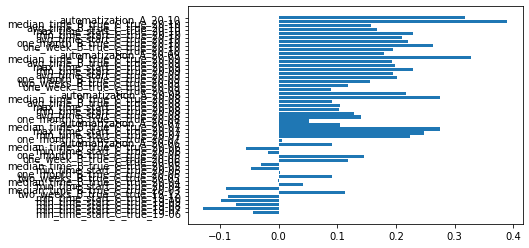

In [14]:
# get importance
importance = model.named_steps['LR'].coef_[0]
# summarize feature importance
for f,v in zip(best_features, importance):
    print('{:35} Score: {:.2f}'.format(f,v))
# plot feature importance
plt.barh([x for x in range(len(importance))], importance)
plt.yticks(np.arange(len(best_features)), best_features)
plt.show()